In [1]:
# default_exp predict

# Predict

> API details.

In [2]:
#export
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import argparse
from time import time
from functools import wraps

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from joblib import Parallel, delayed

import accelerate_simulations.geometry as geom
import accelerate_simulations.preprocess as prep

In [3]:
def timeit(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            print(f"{func.__name__} took: {end_/1000 if end_ > 0 else 0:.2f} s")
    return _time_it

In [12]:
#export
class Predictor:
    def __init__(self, path_model, post_process_func, **config):
        self.config = config
        self.post_process_func = post_process_func
        self.model = self.load_model(path_model) 
    
    def __call__(self, circle_location_seed_list):
        input_fields = self.make_input_fields(circle_location_seed_list)
        pred = self.predict(input_fields)
        pred = self.post_process_func(pred)
        return pred
    
    @staticmethod
    @timeit
    def load_model(path):
        return tf.keras.models.load_model(path)

    @timeit
    def predict(self, input_fields):
        return self.model.predict(input_fields)

    @timeit
    def make_input_fields(self, circle_location_seed_list):
        par = Parallel(n_jobs=-1)
        del_func = delayed(self.make_input_field)
        
        input_fields = par(del_func(s, self.config) 
            for s in circle_location_seed_list)

        return np.stack(input_fields, axis=0)

    @staticmethod
    def make_input_field(circle_location_seed, config):
        abstract_geometry = geom.AbstractGeometry(
                config['circle_density'], 
                config['circle_radius_range'], 
                config['box_size'], 
                config['gap'], 
                seed=circle_location_seed)

        rasterize = geom.GeometryRasterizer(resolution=config['resolution'])
        x, y, raster_image = rasterize(abstract_geometry)

        make_geometric_fields = prep.GeometricFieldMaker(
            config['names_boundary'], 
            geom.element_to_tag, 
            scaling_factor=3)

        input_fields = make_geometric_fields(raster_image, x, y)
        return input_fields


In [13]:
predict = Predictor(
    '../../examples/box_w_aggr/saved_model', 
    post_process_func=lambda x: x*1e-4,
    circle_density=0.9, 
    circle_radius_range=(20,50), 
    box_size=(200,200), 
    gap=10,
    resolution=(128,128),
    names_boundary = ['circles_boundaries']
)

load_model took: 0.71 s


In [18]:
pred = predict(range(1000,1500))

make_input_fields took: 170.74 s
predict took: 14.98 s


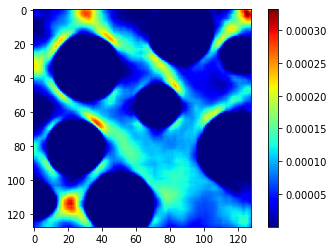

In [20]:
idx = 400

plt.figure()
plt.imshow(np.squeeze(pred[idx]), cmap='jet')
plt.colorbar()